# Filtragem de Imagens

Lucy Miyuki Miyagusiku Narita

RA 182851

In [1]:
import sys

print('Python %s on %s' % (sys.version, sys.platform))

In [2]:
from enum import Enum
import requests
from io import BytesIO
from PIL import Image

import cv2 as cv
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

Abaixo encontram-se algumas funções auxiliares, utilizadas para carregar as imagens (locais ou remotas) em memória e vizualizá-las.

In [3]:
class LoadMode(Enum):
    REMOTE = 1
    LOCAL = 2


def load_image(path, mode=LoadMode.REMOTE):
    """
    loads the pixel matrix that represents the image stored in `path`
    :param path: the file path to the image, it can also be an URL
    :param mode: LOCAL for images stored in the local disk, REMOTE if the `path` is an URL
    :return: the np array representing that image
    """
    if mode == LoadMode.REMOTE:
        response = requests.get(path)
        return np.array(Image.open(BytesIO(response.content))).astype(float)
    elif mode == LoadMode.LOCAL:
        return np.array(Image.open(path))

In [4]:
def plot_img(imgs):
    """
    creates and shows a plot containing the given images
    :param imgs: an array of tuples like the following (img_np_array, title)
    """
    fig = plt.figure(figsize=(10, 10))
    grid = gridspec.GridSpec(np.ceil(len(imgs) / 2.).astype(int), np.ceil(len(imgs) / 2.).astype(int))

    for idx, (img, title) in enumerate(imgs):
        sp = fig.add_subplot(grid[idx])
        norm_img = np.zeros(np.shape(img))
        norm_img = cv.normalize(img, norm_img, 0, 255, cv.NORM_MINMAX)
        plt.imshow(norm_img.astype(int), cmap='gray')
        sp.title.set_text(title)

    plt.show()

Para alterar a imagem de entrada, é necessário alterar a próxima célula.

In [5]:
# img1 = load_image("http://www.ic.unicamp.br/~helio/imagens_png/baboon.png")
img1 = load_image("./imgs/retina-gray.png", LoadMode.LOCAL)

# Introdução

O objetivo deste trabalho é implementar alguns filtros nos domínios espacial e de frequências.
Filtros permitem que sejam aplicados diversos efeitos em imagens, alterando os valores de intensidade dos pixels.

## Execução

O projeto foi desenvolvido em Python 2.7.15 e também foi testado com Python 3.6.7, utilizando os seguintes pacotes como dependências:

- Manipulação de dados
    - `numpy`
    - `opencv`
- Plotting / Visualização
    - `matplotlib`
- Carregamento e download das imagens
    - `requests`
    - `PIL` (`Pillow Imaging Library`)

As imagens utilizadas se encontram na pasta `imgs/`.

## Filtragem no domínio espacial

O domínio espacial refere-se ao próprio plano da imagem, ou seja, ao conjunto de pixels que compõem uma imagem.

### O processo de convolução

A fórmula geral para o processo de convolução é dada por:

$$
g(x,y) = \omega(x,y) \ast f(x,y) = \sum^{a}_{i=-a} \sum^{b}_{j=-b} \omega(i,j)f(x-i, y-j)
$$

onde $g(x,y)$ é o resultado (a imagem filtrada), $f(x,y)$ é a entrada (a imagem original), $\omega$ é a matriz de convoluçao (máscara), $a = \lfloor \frac{m}{2} \rfloor$ e $b = \lfloor \frac{n}{2} \rfloor$

Para a aplicação das máscaras utilizamos a função `filter2D` do `openCV`, ao invés de criarmos nossa própria função de convolução, uma vez que estamos mais interessados na análise crítica do que na implementação da operação de convolução em si.

In [6]:
# edge detection
h1 = np.array(
    [[0., 0., -1., 0., 0.],
     [0., -1., -2., -1., 0.],
     [-1., -2., 16., -2., -1.],
     [0., -1., -2., -1., 0.],
     [0., 0., -1., 0., 0.]])

# gaussian blur 5x5
h2 = np.array(
    [[1., 4., 6., 4., 1.],
     [4., 16., 24., 16., 4.],
     [6., 24., 36., 24., 6.],
     [4., 16., 24., 16., 4.],
     [1., 4., 6., 4., 1.]]) / 256.

unidimensional_h2 = np.array([1., 4., 6., 4., 1.]) / 16.

# Sobel operators
h3 = np.array([[-1., 0., 1.],
               [-2., 0., 2.],
               [-1., 0., 1.]])
h4 = np.array([[-1., -2., -1.],
               [0., 0., 0.],
               [1., 2., 1.]])

In [7]:
def apply_filter(img, f):
    return cv.filter2D(img, -1, f)

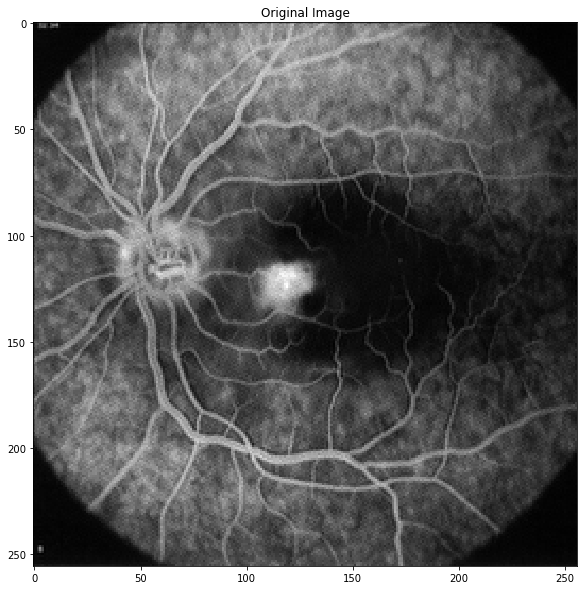

In [8]:
plot_img([(img1, "Original Image")])

O filtro $h_1$ é um filtro passa-alta. Por ser um filtro simples, ele realçará **todos** os pontos de alta frequência, incluindo ruídos.

CPU times: user 701 µs, sys: 424 µs, total: 1.12 ms
Wall time: 519 µs


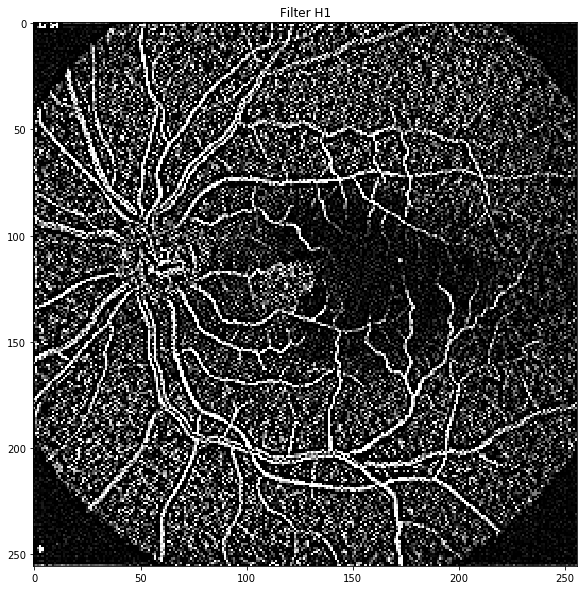

In [9]:
f_img_1 = %time apply_filter(img1, h1)
plot_img([(f_img_1, "Filter H1")])

O filtro $h_2$ é um filtro passa-baixa de suavização Gaussiano (5x5) com $\sigma = 1.0$ aproximado pela expansão binominal $(a+b)^n = \sum^{n}_{k=0} \frac{n!}{k!(n-k)!}a^{n-k}b^{k}$.

CPU times: user 471 µs, sys: 311 µs, total: 782 µs
Wall time: 273 µs


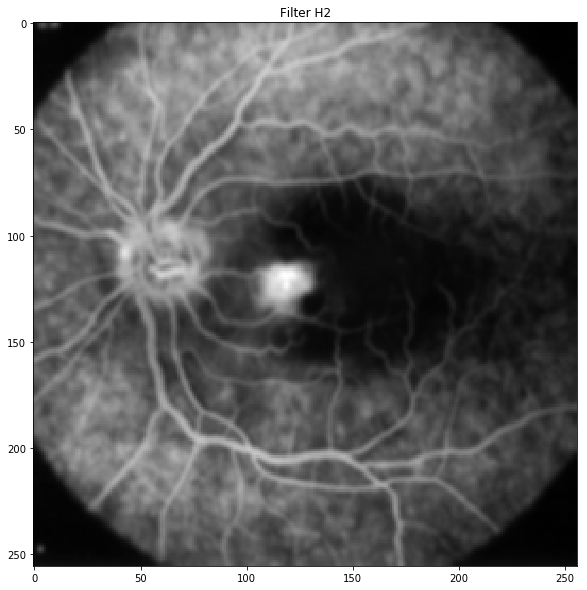

In [10]:
f_img_2 = %time apply_filter(img1, h2)
plot_img([(f_img_2, "Filter H2")])

Essa máscara separável e pode ser obtida a partir da convolução das seguintes máscaras unidimensionais:

$$
h2' = \frac{1}{16}
\begin{bmatrix}
    1 \\
    4 \\
    6 \\
    4 \\
    1
\end{bmatrix}
$$

e 

$$
h2'' = \frac{1}{16}
\begin{bmatrix}
    1 & 4 & 6 & 4 & 1
\end{bmatrix}
$$

CPU times: user 4.09 ms, sys: 4.07 ms, total: 8.16 ms
Wall time: 3.98 ms


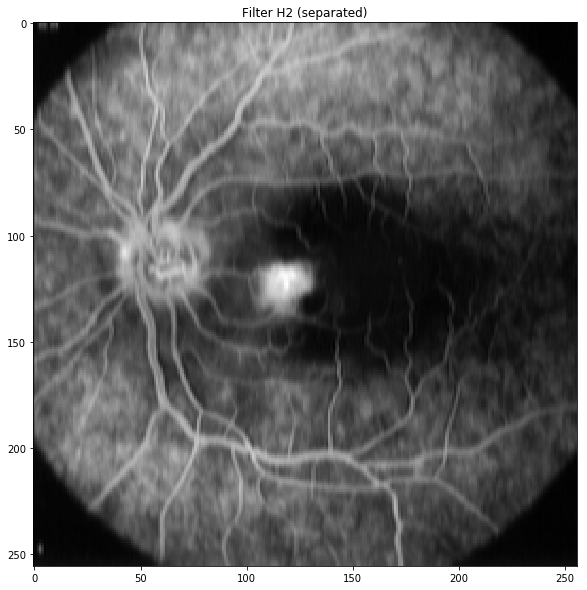

In [11]:
f_img_2_separated = %time apply_filter(apply_filter(img1, np.transpose(unidimensional_h2)), unidimensional_h2)
plot_img([(f_img_2_separated, "Filter H2 (separated)")])

Os filtro $h_3$ e $h_4$ são _Operadores de Sobel_ ou _Filtros de Sobel_ para detecção de bordas.
O filtro $h_3$ detecta as bordas verticais enquanto o filtro $h_4$ as bordas horizontais. A combinação dos dois ($h_5$), portanto compõe as bordas horizontais e verticais da imagem.

CPU times: user 132 µs, sys: 95 µs, total: 227 µs
Wall time: 118 µs


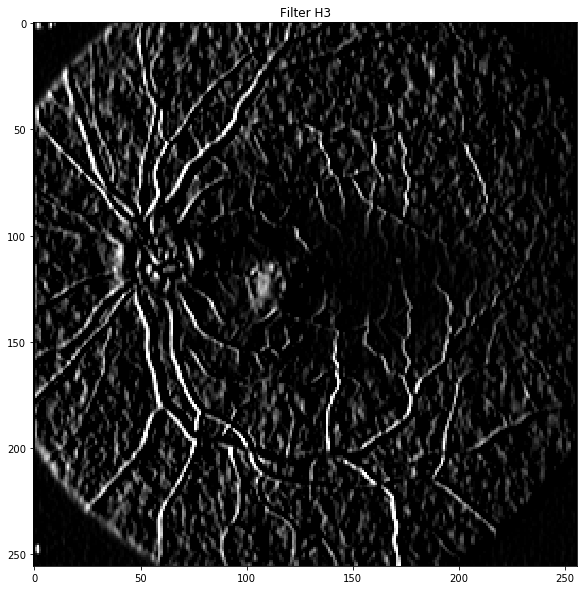

In [12]:
f_img_3 = %time apply_filter(img1, h3)
plot_img([(f_img_3, "Filter H3")])

CPU times: user 192 µs, sys: 145 µs, total: 337 µs
Wall time: 165 µs


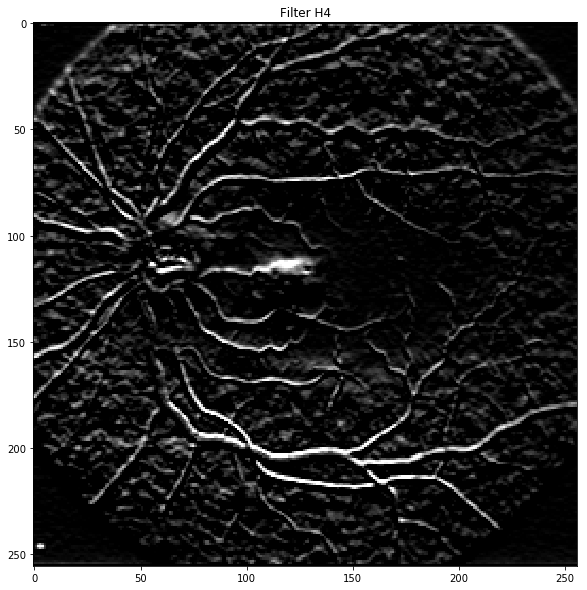

In [13]:
f_img_4 = %time apply_filter(img1, h4)
plot_img([(f_img_4, "Filter H4")])

CPU times: user 6.15 ms, sys: 2.57 ms, total: 8.73 ms
Wall time: 3.67 ms


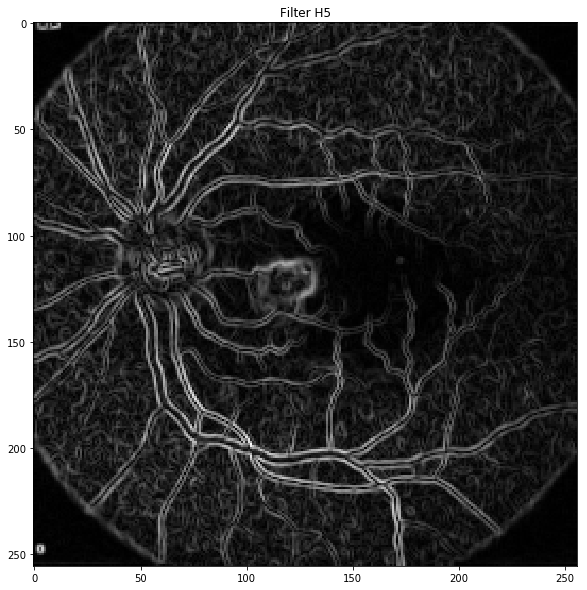

In [14]:
f_img_5 = %time np.sqrt(np.square(apply_filter(img1 / 255., h3)) + np.square(apply_filter(img1 / 255., h4)))
plot_img([(f_img_5, "Filter H5")])

In [15]:
def fourier_transform(img):
    # apply dft (appr. by fast fourier transform)
    f = np.fft.fft2(img)
    # shift zero-frequency component to center
    fshift = np.fft.fftshift(f)
    return fshift


def reverse_dft(img):
    # shift zero-frequency component to (0,0)
    fshift = np.fft.ifftshift(img)
    # apply reverse fast fourier transform
    img_back = np.fft.ifft2(fshift)
    return img_back

O filtro Gaussiano é dado pela seguinte função de transferência:

$$
\begin{equation*}
    H(u,v) = \exp \left( {-\frac{D^2(u,v)}{2D_0^2}} \right)
\end{equation*}
$$

em que $D_0$ é a frequência de corte e $D(u,v)$ é a distância do pixel $(u,v)$ até a componente de frequência zero (origem do plano de frequência).

In [16]:
def fourier_gaussian(img, cutoff_frequencies):
    # image size
    height, width = np.shape(img)
    # calc. center point
    center_y, center_x = height / 2, width / 2
    # calc. all pixels indexes of the img
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y)

    # calc. all pixel distance from center
    dx, dy = np.abs(X - center_x), np.abs(Y - center_y)

    fft_image = fourier_transform(img)
    # calc. frequency magnitude spectrum of the original img
    magnitude_spectrum = 20 * np.log(np.abs(fft_image))
    plot_img([(np.abs(magnitude_spectrum), "Original Image Magnitude Spectrum")])

    for cut_freq in cutoff_frequencies:
        # calc. 2*D_0^2
        d0 = 2 * cut_freq * cut_freq
        # calc. square of the distance from center for every pixel
        sqr_distance = np.square(dx) + np.square(dy)
        # generate the gaussian mask
        gaussian_mask = np.exp(-(sqr_distance / d0))
        # apply the mask to the dft of the image
        filtered_img = fft_image * gaussian_mask
        # calc. filtered image magnetude spectrum
        spectrum = 2000 * np.log(np.abs(filtered_img))
        # finally, return img to spatial domain for plotting
        filtered_img_vis = reverse_dft(filtered_img)

        plot_img([
            (gaussian_mask, "Gaussian Mask (Cutoff Freq: {})".format(cut_freq)),
            (spectrum, "Filtered Image Magnitude Spectrum (Cutoff Freq: {})".format(cut_freq)),
            (img, "Original".format(cut_freq)),
            (np.abs(filtered_img_vis), "Filtered Image (Cutoff Freq: {})".format(cut_freq))
        ])

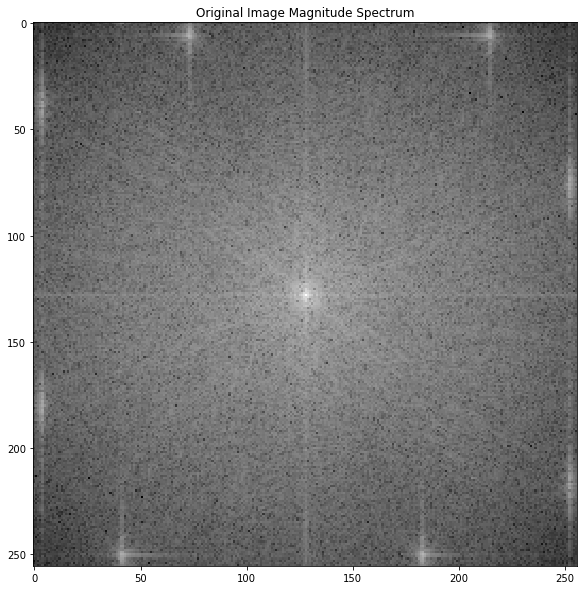

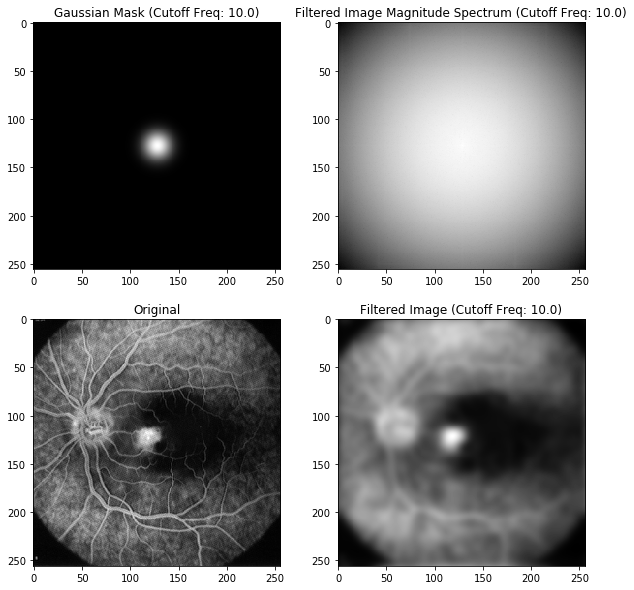

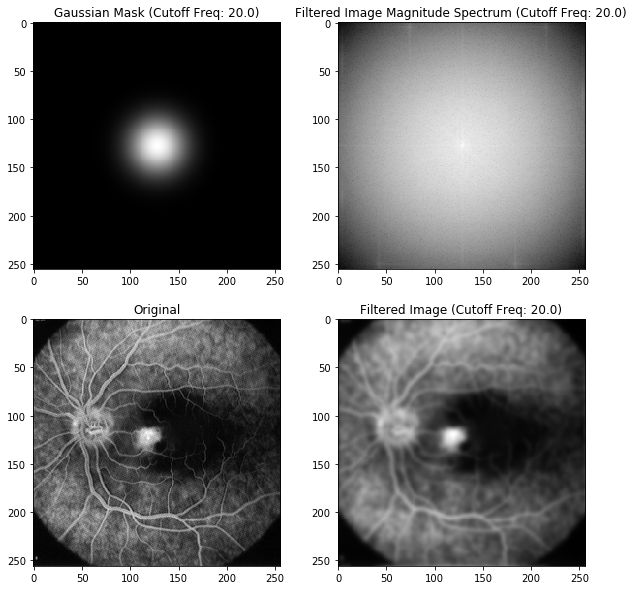

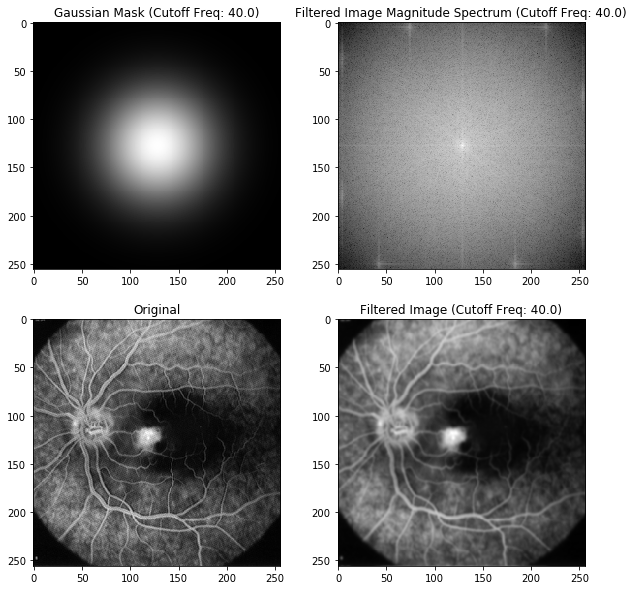

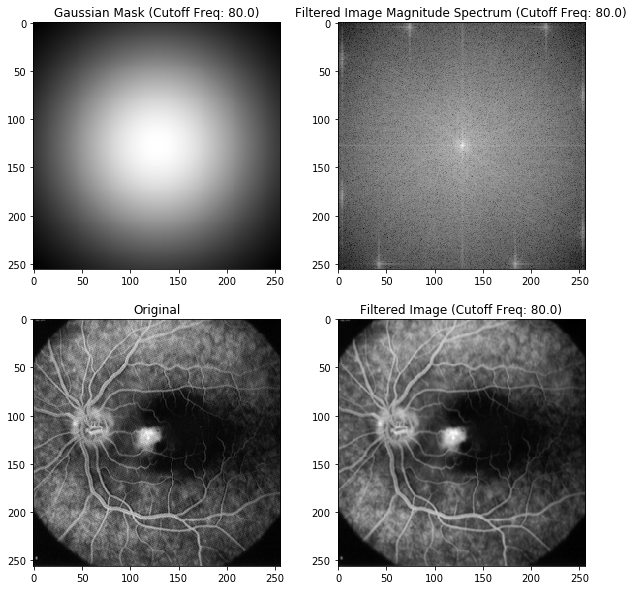

In [17]:
fourier_gaussian(img1, [10., 20., 40., 80.])